### What are partial dependence plots?

Partial dependence plots (PDPs) help visualize relationship between features and predicted outcomes (could be labels for binary/ multi-class classification or continuous target for regression). They are are particularly helpful with black-box models like Random Forests, Gradient Boosted Trees, Neural Networks where interpretability is an issue. 

PDPs provide a way to look at the directionality of feature(s) with respect to the predicted outcome. Though ensemble methods like random forests and gradient boosted trees give us a way to measure *importance* of features, which give a sense of which
features tend to have the most effect on the outcome, but there is no way to measure the directionality. For instance, how does one understand if increasing or decreasing the value of a feature change the predicted outcome? Is the change linear or monotonic or possbily non-linear and non-monotonic? This is a natural and an important question. One can imagine a scenario in which the business would like to see how changing one of the drivers would vary the outcome. 

***Partial dependence plots, introduced by Friedman in 2001, can help in interpreting complex machine learning algorithms by quantifying the directionaity of relationship between the outcome and features.***

PDPs help visualize the relationship between a subset of features (typically 1-3) and the response, while accounting for the *average* effect of the other predictors in the model. 

### How does the algorithm work?

The algorithm is deceptively simple! 

Let $x_1$ be the predictor of interest with unique values $\{x_{11}, x_{12}, ...,x_{1l} \}$. Partial dependence plots fo $x_1$ is constructed as follows. 

For $i \in \{1, 2,..,l \}$, 

*Step 1* 

a. Copy the training data and replace the original values of $x_1$ with $x_{1i}$

b. Compute the vector of predicted values from the modified copy of the training data. 

c. Compute the average of this vector to obtain the partial dependence function $\bar{f}(x_1)$. 

*Step 2*

Plot the pairs $(x_i, \bar{f}(x_i))$ for $i=1, 2,..l$

### Few words of caution

In the above algorithm, we can take multiple features and compute the partial dependence function for these features. Taking one feature gives a 1-dimensional curve. Due to limitations of huma perception we can take at most 2-3 features for producing partial dependence plots. 

Note that this requires a pass over the data for each set of joint values of training data or which the partial dependence 
function is to be evaluated. This can be computationally intensive. (However, with decision trees partial dependence function can be quickly evaluated from the trees themselves without reference to the data, which is why `sklearn` currently implements
partial dependence function only for gradient boosted trees.)

Aslo note that partial dependence functions represent the effect of the feature $X_i$ on the prediction *after accounting for the average effects of other variables on the prediction. They are not the effects of $X_i$ on prediction ignoring the effects of other variables.*

***`sklearn` currently implements partial dependence plots only for gradient boosted trees. In this project I am aim to extend the functionality to any classifer or regression model.***

The code for the custom partial dependence implementation can be found in `partial_dependence.py`. 

Without further ado, let's get started and walk through a couple of examples of partial dependence plots. 

### Example 1

We will use the California housing dataset and look at how partial dependence plots can help in interpretation for regression and classification models. In this example we will fit two classifiers and try to infer trends from partial dependence plots

In [1]:
# Boilerplate 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets.california_housing import fetch_california_housing
from sklearn.metrics import confusion_matrix, classification_report

# Create a dataframe with target variable as the median price label, which takes 3 values 'low', 'medium' and 'high'

cal_housing = fetch_california_housing()
df = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
df['price_cat'] = pd.qcut(cal_housing.target, q=3, labels=['low', 'medium', 'high'])

# Train test split
features = df.drop("price_cat", axis=1)
labels = df["price_cat"]

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42,
                                                                            stratify=labels)

In [2]:
# Fit a classifer
print("Training GBC...")
gbc = GradientBoostingClassifier(loss='deviance',
                                 n_estimators=1500, 
                                 max_depth=4,
                                 learning_rate=0.1,
                                 random_state=1)
gbc.fit(features_train, labels_train)
print("Done")

print(' GBC:\n {}\n'.format(classification_report(labels_test, gbc.predict(features_test))))
confusion_matrix(labels_test, gbc.predict(features_test))

Training GBC...
Done
 GBC:
              precision    recall  f1-score   support

       high       0.87      0.83      0.85      1376
        low       0.86      0.87      0.87      1377
     medium       0.73      0.76      0.74      1375

avg / total       0.82      0.82      0.82      4128




array([[1144,   11,  221],
       [  15, 1195,  167],
       [ 151,  180, 1044]], dtype=int64)

In [3]:
# Fit another classifier
print("Training RF...")
rf = RandomForestClassifier(random_state=0)
rf.fit(features_train, labels_train)
print("Done")

print(' RF:\n {}\n'.format(classification_report(labels_test, rf.predict(features_test))))
confusion_matrix(labels_test, rf.predict(features_test))

Training RF...
Done
 RF:
              precision    recall  f1-score   support

       high       0.82      0.83      0.83      1376
        low       0.82      0.86      0.84      1377
     medium       0.71      0.67      0.69      1375

avg / total       0.78      0.79      0.79      4128




array([[1141,   22,  213],
       [  24, 1183,  170],
       [ 223,  229,  923]], dtype=int64)

Now that the classifiers have been fit we can select a feature and the label for which the partial 
dependence function is to be calculated. Since the performance of classifiers is decent we can trust the results of 
the partial dependence plots. (Note that in classification problems the 'prediction' is the probability of belonging to a class.
Hence for plotting we also need to specify the label for which the 1D partial dependence plot is to be drawn.)

In [4]:
feature_name ='AveOccup'
label_name='low'

Calculating partial dependence...


Text(0.5,0,'AveOccup')

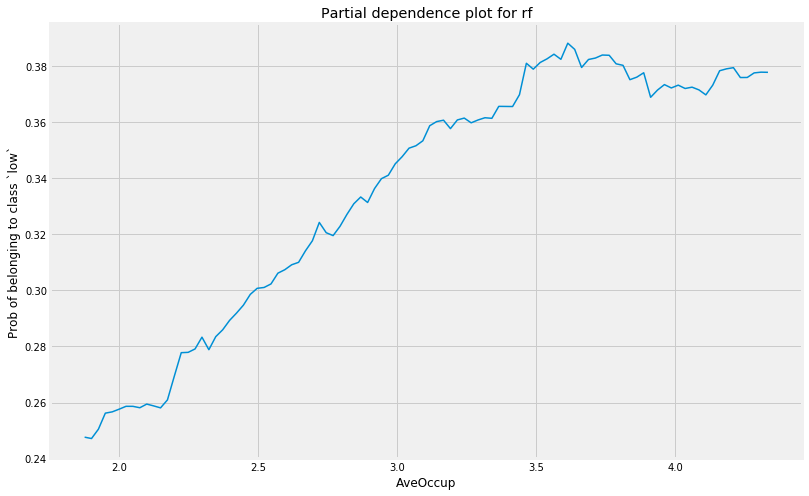

In [5]:
# Compute partial dependence and customize the plot
partial_dependence_rf = partial_dependence.PDP(model=rf,
                         n_classes=3,
                         feature_name=feature_name,
                         training_df=features_train,
                         percentile=(0.05, 0.95),
                         n_grid=100)
fig, ax = partial_dependence_rf.plot_partial_dependence(label_name=label_name)
ax.set_title('Partial dependence plot for rf')
ax.set_ylabel('Prob of belonging to class `{}`'.format(label_name))
ax.set_xlabel(feature_name)

Calculating partial dependence...


Text(0.5,0,'AveOccup')

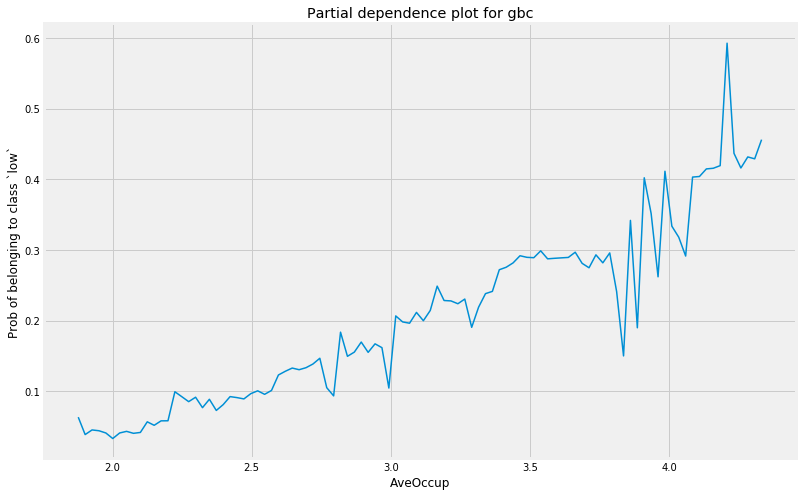

In [6]:
partial_dependence_gbc = partial_dependence.PDP(model=gbc,
                         n_classes=3,
                         feature_name=feature_name,
                         training_df=features_train,
                         percentile=(0.05, 0.95),
                         n_grid=100)
fig, ax = partial_dependence_gbc.plot_partial_dependence(label_name=label_name)
ax.set_title('Partial dependence plot for gbc')
ax.set_ylabel('Prob of belonging to class `{}`'.format(label_name))
ax.set_xlabel(feature_name)

***How do we interpret these plots?***

Both the plots caculate the probability of belonging to a particular label (in this case the label `low`) as the target feature
(`AveOccup`) increases and takes 100 (`n_grid`) equally spaced values between 5-95 percentile. 

The plots for both the models show similar trend. As the value of the target feature increases the probability of the (fake) data point landing in the class `low` increases. The gradient boosted classifer is much more confident about this trend and can be seen to place a probability of more than 0.5 as the value of the target feature increases. The random forest model, though showing a similar trend, is not as confident and can be seen to place a lower probability of around 0.38 as value of target feature increases. 

TL;DR: The partial dependence plots depend on the model which has been fit, and better the predictive ability of the model, the more confident we can be about inferring trends from partial dependence plots.

### Example 2
In this example we will fit two regressors and try to infer trends from the partial dependence plots. 

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

In [8]:
# Load Data
cal_housing = fetch_california_housing()
df_reg = pd.DataFrame(data=cal_housing.data, columns=cal_housing.feature_names)
features = df_reg
labels = cal_housing.target

# Train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, 
                                                                            test_size=0.2, 
                                                                            random_state=42)

In [9]:
# Fit a regressor
print("Training RF regressor...")
reg_rf = RandomForestRegressor(n_estimators=1500, 
                                 max_depth=None,
                                 random_state=1)
reg_rf.fit(features_train, labels_train)
print("Done")
r2_score(reg_rf.predict(features_test), labels_test)

Training RF regressor...
Done


0.751980587078472

In [10]:
# Fit another regressor
print("Training GB regressor...")
reg_gb = GradientBoostingRegressor(loss='ls',
                                   n_estimators=1500,
                                   random_state=1
                                   )
reg_gb.fit(features_train, labels_train)
print("Done")
r2_score(reg_gb.predict(features_test), labels_test)

Training GB regressor...
Done


0.8029871842927676

Now that the regressors have been fit we can select a feature for which the partial 
dependence function is to be calculated. Since the performance of regressors is decent we can trust the results of 
the partial dependence plots. (Since the models predict the actual outcome there is no need to specify any label name.)

In [12]:
feature_name ='AveOccup'

Calculating partial dependence...


Text(0.5,0,'AveOccup')

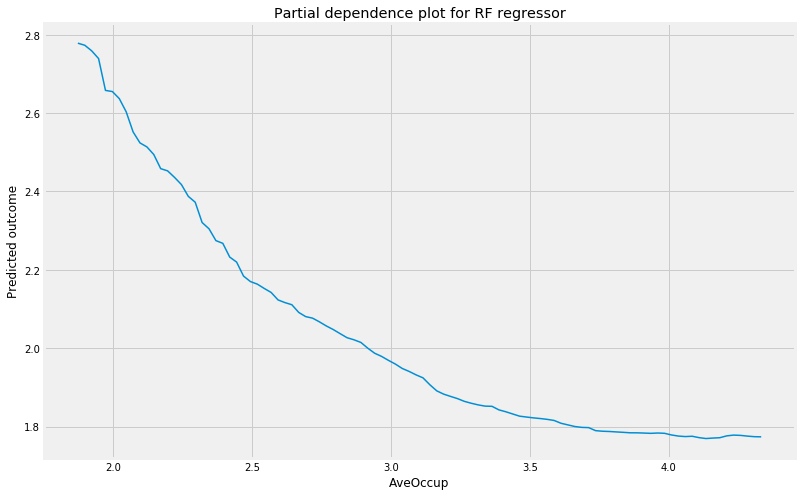

In [13]:
# Compute the partial dependence function
partial_dependence_reg_rf = partial_dependence.PDP(model=reg_rf,
                                                   feature_name=feature_name,
                                                   training_df=features_train,
                                                   percentile=(0.05, 0.95),
                                                   n_grid=100)
# Customize plot
fig, ax = partial_dependence_reg_rf.plot_partial_dependence()
ax.set_title('Partial dependence plot for RF regressor')
ax.set_ylabel('Predicted outcome')
ax.set_xlabel(feature_name)

Calculating partial dependence...


Text(0.5,0,'AveOccup')

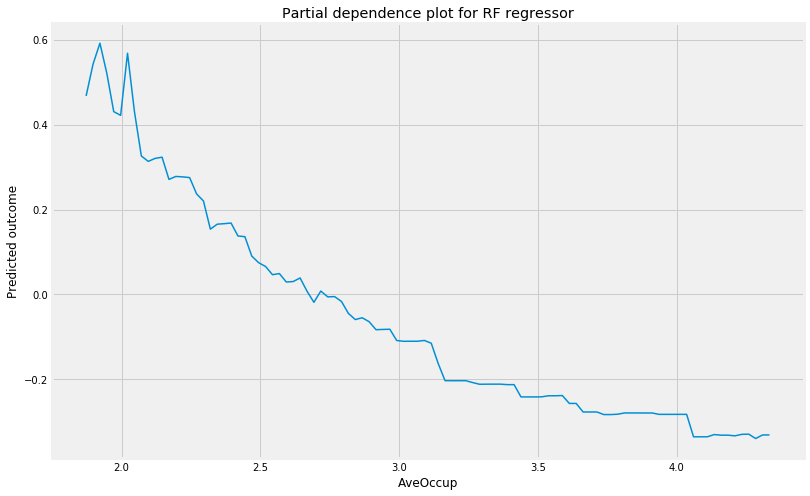

In [20]:
partial_dependence_reg_gb = partial_dependence.PDP(model=reg_gb,
                                                   feature_name=feature_name,
                                                   training_df=features_train,
                                                   percentile=(0.05, 0.95),
                                                   n_grid=100)
fig, ax = partial_dependence_reg_gb.plot_partial_dependence()
ax.set_title('Partial dependence plot for RF regressor')
ax.set_ylabel('Predicted outcome')
ax.set_xlabel(feature_name)

***Wait, why is there a difference in the y axis values for the regressor plots?***

We notice similar trends in partial dependence plots for both the models. An increase in `AveOccup` results in decrease of the predicted outcome. Note that the y-axis for the random forest plot is positive but the y-axis for the Grdient Boosted model
dips below zero. This is because the predicted function in both the cases is different. ***For gradient boosted model I used 
sklearn's implementation which subtracts the mean from the final result, while for the random forest model the predicted function is calculated from scratch and no such subtraction takes place.***

### Future work

Partial dependence plots are very useful in interpreting results of black-box models and more work needs to be done to extend the scope of this project. Some extensions could be to include contour plots and modify sklearn's gradient boosted regression plot so that it outputs actual predictions. 